# Calculate Bullish Percent Index (BPI) for S&P 500

In [1]:
# Import credentials

import json
f = open("/. .<your file path here> . . /credentials.json")
credentials = json.load(f)

file_path = credentials['file_path']
intrinio_key = credentials['intrinio_key']
aws_key = credentials['aws_access_key']
aws_secret_key = credentials['aws_secret_key']
rds_host = credentials['rds_host']
rds_user = credentials['rds_user']
rds_password = credentials['rds_password']
rds_database = credentials['rds_database']
rds_charset = credentials['rds_charset']


In [16]:
# Import Intrinio libraries

import time
import intrinio_sdk as intrinio
from intrinio_sdk.rest import ApiException

intrinio.ApiClient().configuration.api_key['api_key'] = intrinio_key

# Import the usual Python libraries

from tqdm.notebook import tqdm, trange  # to be used to track progress in loop iterations
import pandas as pd
import numpy as np
import datetime as datetime
from datetime import datetime, date, time, timedelta

# Import the AWS libraries

import boto3
from boto3.s3.transfer import TransferConfig
from boto3.s3.transfer import S3Transfer
import io
import pyarrow as pa
import pyarrow.parquet as pq

# Import SQL libraries

import mysql.connector 
from mysql.connector import errorcode
from sqlalchemy import create_engine

# Declare the local File Path:

global my_path
my_path = file_path


In [3]:
# Run SQL query to calculate BPI history

def get_bpi_history():

    from datetime import datetime, date, time, timedelta

    global result
    global df_bpi_hist

    mydb = mysql.connector.connect(
      host = rds_host,
      user = rds_user,
      password = rds_password,
      database = rds_database
    )

    mycursor = mydb.cursor()

    mycursor.execute("SELECT p.date, SUM(p.signal_name = 'BUY') / COUNT(*) \
                        FROM base_pnf_data_historical AS p \
                        LEFT JOIN custom_lists AS c ON p.ticker = c.ticker \
                        WHERE p.date > '2021-01-01' \
                        AND c.list_names LIKE 'SP500%' \
                        GROUP BY p.date;")

    result = mycursor.fetchall()
    df_bpi_hist = pd.DataFrame(result, columns = ['date', 'bpi'])
    df_bpi_hist['bpi'] = df_bpi_hist['bpi'].astype(float)
    df_bpi_hist['percent_change'] = df_bpi_hist['bpi'].pct_change()
    

    return df_bpi_hist
    
    

In [13]:
def generate_pnf_calcs(df_bpi_hist):
    
    global df_bpi_pnf_hist
    
    boxSize = .02
    reversalBoxes = 3
    reversalAmount = boxSize * reversalBoxes
    
    data = df_bpi_hist.copy()
    data.reset_index(drop = True, inplace = True)
    
    # Add columns for Plot Symbol, Reversal, Signal Name and Percent Change and other P&F calcs
    
    data['plot_symbol'] = np.nan
    data['reversal'] = 0
    data['signal_name'] = np.nan
    data['high_point'] = np.nan
    data['last_high_point'] = np.nan
    data['prev_high_point'] = np.nan
    data['low_point'] = np.nan
    data['last_low_point'] = np.nan
    data['prev_low_point'] = np.nan
    data['entry_x'] = np.nan
    data['entry_o'] = np.nan
    data['next_entry'] = np.nan
    data['stop_loss'] = np.nan
    data['target_price'] = np.nan
    

    # Reorder the columns
    
    data = data[['date', 'bpi', 'percent_change', 'plot_symbol', 'reversal', 'signal_name', 'high_point', 
                 'last_high_point', 'prev_high_point', 'low_point', 'last_low_point', 'prev_low_point', 'entry_x', 
                 'entry_o', 'next_entry', 'stop_loss', 'target_price']]

    
    # Set all starting High Points and Low Points equal to the last record for each ticker from the historical data table.

    data.loc[0, 'plot_symbol'] = 'X'      #On Day 1, plotSymbol = "X"
    data.loc[0, 'signal_name'] = 'BUY'    #On Day 1, signalName = "BUY"

    high_point = data['bpi'].iloc[0]
    low_point = data['bpi'].iloc[0]
    last_high_point = data['bpi'].iloc[0]
    last_low_point = data['bpi'].iloc[0]
    entry_x = data['bpi'].iloc[0]
    entry_o = data['bpi'].iloc[0]
    prev_high_point = data['bpi'].iloc[0]
    prev_low_point = data['bpi'].iloc[0]
    target_price = data['bpi'].iloc[0]

    # Start the loop on the second day, loop through each day's bpi price after that.
    for i in range(1, len(data)):

        if data['plot_symbol'].iloc[i - 1] == 'X':   #If previous Plot Symbol = "X", then:

            if data['bpi'].iloc[i] >= data['bpi'].iloc[i - 1]:     #If current price >= previous price, then:
                data.loc[i, 'plot_symbol'] = 'X'        # Today's Plot Symbol = "X".
                data.loc[i, 'signal_name'] = data['signal_name'].iloc[i - 1]    #and copy yesterday's signal to today.

                if data['bpi'].iloc[i] > high_point:    #And if today's price is higher than the most recent high price, 
                    high_point = data['bpi'].iloc[i]       #then make today's price the  high price,
                    data.loc[i, 'signal_name'] = data['signal_name'].iloc[i - 1]   #and copy yesterday's signal to today.

                if data['bpi'].iloc[i] > last_high_point:  #And if today's price is higher than the high point from the last X column,
                    data.loc[i, 'signal_name'] = "BUY"           #then today's signal = "BUY".

            elif data['bpi'].iloc[i] < high_point * (1 - reversalAmount):     #Else if today's price is less than the previous high times 1 - reversal,
                data.loc[i, 'plot_symbol'] = 'O'                                     #the Plot Symbol reverses to "O",
                low_point = data['bpi'].iloc[i]                                   #and the  low point is today's price,
                data.loc[i, 'reversal'] = 1                                         #and reversal = 1,
                prev_high_point = last_high_point                                        #and prev_high_point = last_high_point, saving this ValueSignal to use in the Target Price calc below
                last_high_point = high_point                                               #and last_high_point = most recent high point
                entry_o = data['bpi'].iloc[i - 1]                                 #and entry_o = previous day's closing price, used in next_entry and stop_loss calcs

                if data['bpi'].iloc[i] < last_low_point:   #And if today's price is lower than the low point from the last O column,
                    data.loc[i, 'signal_name'] = "SELL"          #then today's signal = "SELL".
                else:
                    data.loc[i, 'signal_name'] = data['signal_name'].iloc[i - 1]   #Else copy yesterday's signal to today.

            else:
                data.loc[i, 'plot_symbol'] = 'X'  #Else, Plot Symbol = "X" (price is down but not enough to triger a reversal)
                data.loc[i, 'signal_name'] = data['signal_name'].iloc[i - 1]   #and copy yesterday's signal to today.


        if data['plot_symbol'].iloc[i - 1] == 'O':   #If previous Plot Symbol = "O", then:

            if data['bpi'].iloc[i] < data['bpi'].iloc[i - 1]:            #If current price <= previous price, then:
                data.loc[i, 'plot_symbol'] = 'O'         # Today's Plot Symbol = "O".
                data.loc[i, 'signal_name'] = data['signal_name'].iloc[i - 1]

                if data['bpi'].iloc[i] < low_point:       #And if today's price is lower than the most recent low price, 
                    low_point = data['bpi'].iloc[i]         #then make today's price the  low price.
                    data.loc[i, 'signal_name'] = data['signal_name'].iloc[i - 1]   #and copy yesterday's signal to today.

                if data['bpi'].iloc[i] < last_low_point:   #And if today's price is lower than the low point from the last O column,
                    data.loc[i, 'signal_name'] = "SELL"         #then today's signal = "SELL".


            elif data['bpi'].iloc[i] > low_point * (1 + reversalAmount):       #Else if today's price is greater than the previous high, times 1 + reversal,
                data.loc[i, 'plot_symbol'] = 'X'                                       #the Plot Symbol reverses to "X",
                high_point = data['bpi'].iloc[i]                                    #and the  high point is today's price,
                data.loc[i, 'reversal'] = 1                                           #and reversal = 1,
                prev_low_point = last_low_point                                            ##and prev_low_point = last_low_point, saving this ValueSignal to use in the Target Price calc below
                last_low_point = low_point                                                   #and last_low_point = most recent low point
                entry_x = data['bpi'].iloc[i - 1]                                   #and entry_x = previous day's closing price, used in next_entry and stop_loss calcs

                if data['bpi'].iloc[i] > last_high_point:  #And if today's price is higher than the high point from the last X column,
                    data.loc[i, 'signal_name'] = "BUY"          #then today's signal = "BUY".

                else:
                    data.loc[i, 'signal_name'] = data['signal_name'].iloc[i - 1]     #Else copy yesterday's signal to today.

            else:
                data.loc[i, 'plot_symbol'] = 'O'  #Else, Plot Symbol = "O" (price is up but not enough to triger a reversal)
                data.loc[i, 'signal_name'] = data['signal_name'].iloc[i - 1]   #and copy yesterday's signal to today.

        data.loc[i, 'high_point'] = high_point            #high_point = current "high_point"
        data.loc[i, 'low_point'] = low_point             #low_point = current "low_point"
        data.loc[i, 'last_high_point'] = last_high_point  #last_high_point = current "last_high_point"
        data.loc[i, 'last_low_point'] = last_low_point    #last_low_point = current "last_low_point"
        data.loc[i, 'prev_high_point'] = prev_high_point  #prev_high_point = current "prev_high_point"
        data.loc[i, 'prev_low_point'] = prev_low_point    #prev_low_point = current "prev_low_point"

        if data['signal_name'].iloc[i] == "BUY":

            next_entry = entry_o * (1 + boxSize)         #Set next_entry at one box up from the price at the last reversal from X to O, which should be near the top of the previous X column
            data.loc[i, 'next_entry'] = next_entry
            stop_loss = entry_x * (1 - boxSize)          #Set the stop_loss at one box down from the price at the last reversal from O to X, which should be near the bottom of the previous O column
            data.loc[i, 'stop_loss'] = stop_loss

            if data['signal_name'].iloc[i - 1] == "SELL":
                target_price = ((last_high_point - prev_low_point) * reversalBoxes) + prev_low_point   #Upon reversal from SELL to BUY, set the target_price equal to the size of the previous X column,
                                                                                                # times the box size, added to the bottom of the previous X column. Once calculated, it does not
                                                                                                # change for the balance of the current BUY signal.
            data.loc[i, 'target_price'] = target_price

        else:
            next_entry = entry_x * (1 - boxSize)         #Set next_entry at one box down from the price at the last reversal from O to X, which should be near the bottom of the previous O column
            data.loc[i, 'next_entry'] = next_entry
            stop_loss = entry_o * (1 + boxSize)          #Set the stop_loss at one box up from the price at the last reversal from X to O, which should be near the top of the previous X column
            data.loc[i, 'stop_loss'] = stop_loss

            if data['signal_name'].iloc[i - 1] == "BUY":
                target_price = prev_high_point - ((prev_high_point - last_low_point) * reversalBoxes)  #Upon reversal from BUY to SELL, set the target_price equal to the size of the previous O column,
                                                                                                # times the box size, subtracted from the top of the previous O column. Once calculated, it does not
                                                                                                # change for the balance of the current SELL signal.
            data.loc[i, 'target_price'] = target_price
            
        data.loc[i, 'entry_x'] = entry_x            #entry_x = current "entry_x"
        data.loc[i, 'entry_o'] = entry_o            #entry_o = current "entry_o"

    #data_list = data.values.tolist()
    df_bpi_pnf_hist = data.copy()
    
    return df_bpi_pnf_hist


In [14]:
# Run the calculation process.

get_bpi_history()
generate_pnf_calcs(df_bpi_hist)



,date,bpi,percent_change,plot_symbol,reversal,signal_name,high_point,last_high_point,prev_high_point,low_point,last_low_point,prev_low_point,entry_x,entry_o,next_entry,stop_loss,target_price
0,2021-01-04,0.8294,NaN,X,0,BUY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-05,0.8274,-0.002411,X,0,BUY,0.8294,0.8294,0.8294,0.8294,0.8294,0.8294,0.8294,0.8294,0.845988,0.812812,0.8294
2,2021-01-06,0.8333,0.007131,X,0,BUY,0.8333,0.8294,0.8294,0.8294,0.8294,0.8294,0.8294,0.8294,0.845988,0.812812,0.8294
3,2021-01-07,0.8353,0.002400,X,0,BUY,0.8353,0.8294,0.8294,0.8294,0.8294,0.8294,0.8294,0.8294,0.845988,0.812812,0.8294
4,2021-01-08,0.8333,-0.002394,X,0,BUY,0.8353,0.8294,0.8294,0.8294,0.8294,0.8294,0.8294,0.8294,0.845988,0.812812,0.8294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,2021-12-20,0.5567,-0.037684,O,0,SELL,0.7396,0.7396,0.7555,0.5567,0.6600,0.6660,0.6958,0.7137,0.681884,0.727974,0.8294
244,2021-12-21,0.5706,0.024969,O,0,SELL,0.7396,0.7396,0.7555,0.5567,0.6600,0.6660,0.6958,0.7137,0.681884,0.727974,0.8294
245,2021-12-22,0.5765,0.010340,O,0,SELL,0.7396,0.7396,0.7555,0.5567,0.6600,0.6660,0.6958,0.7137,0.681884,0.727974,0.8294
246,2021-12-23,0.5885,0.020815,O,0,SELL,0.7396,0.7396,0.7555,0.5567,0.6600,0.6660,0.6958,0.7137,0.681884,0.727974,0.8294


In [15]:
# Export the BPI dataframe to a CSV file.

df_bpi_pnf_hist.to_csv(path_or_buf = my_path + "/df_bpi_pnf_hist.csv", index = False)

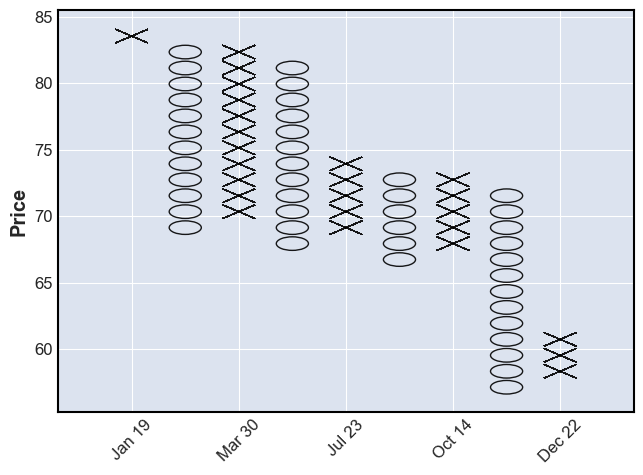

In [70]:
# Look at BPI data in PnF chart.

import mplfinance as mpf  # Import the MPL Finance charting library

mpl_data = df_bpi_hist.copy()   # Copy the BPI dataframe and convert it to a "pseudo-OHLC" format
mpl_data['Open'] = np.nan
mpl_data['High'] = np.nan
mpl_data['Low'] = np.nan
mpl_data.rename(columns = {'bpi':'Close'}, inplace = True)
mpl_data['Close'] = mpl_data['Close'] * 100
mpl_data['Volume'] = np.nan

mpl_data.set_index('date', inplace = True) # Move the date column to the index level

mpf.plot(mpl_data, type = 'pnf', pnf_params=dict(box_size = 1.2, reversal = 3))   # Create the P&L plot


